In [5]:
import torch
import torchvision

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms

# Definimos una transformación para preprocesar las imágenes
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Redimensionamos las imágenes a 28 x 28
    transforms.ToTensor(),  # Convertimos las imágenes a tensores
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Descargamos el conjunto de entrenamiento del GTSRB y aplicamos la transformación definida
train_set = torchvision.datasets.GTSRB(
    root='./data',split = 'train', download=True, transform=transform)

# Descargamos el conjunto de prueba del GTSRB y aplicamos la transformación definida
test_set = torchvision.datasets.GTSRB(
    root='./data', split = 'test', download=True, transform=transform)

# Creamos los dataloaders para cargar los datos en lotes durante el entrenamiento
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)


In [7]:
def imshow(img):
    img = img / 2 + 0.5     # Desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


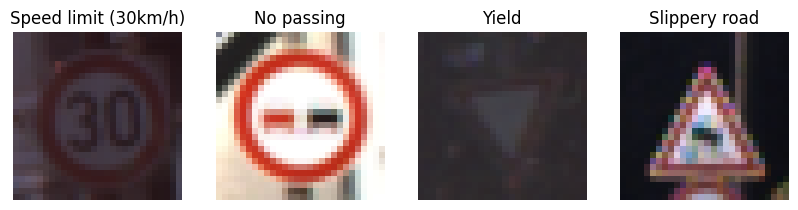

In [9]:
import matplotlib.pyplot as plt
import numpy as np

classes = ['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)',
           'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)',
           'Speed limit (120km/h)', 'No passing', 'No passing for vehicles over 3.5 metric tons',
           'Right-of-way at the next intersection', 'Priority road', 'Yield', 'Stop', 'No vehicles',
           'Vehicles over 3.5 metric tons prohibited', 'No entry', 'General caution', 'Dangerous curve to the left',
           'Dangerous curve to the right', 'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right',
           'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 'Beware of ice/snow',
           'Wild animals crossing', 'End of all speed and passing limits', 'Turn right ahead', 'Turn left ahead',
           'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory',
           'End of no passing', 'End of no passing by vehicles over 3.5 metric tons']
# Obtener un lote de datos de entrenamiento
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Mostrar las imágenes
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for i in range(4):
    ax = axes[i]
    # Normalizar la imagen
    img_norm = (images - images.min()) / (images.max() - images.min())

    # Mostrar la imagen
    ax.imshow(np.transpose(img_norm[i], (1, 2, 0)))
    #ax.imshow(np.transpose(images[i], (1, 2, 0)))
    ax.set_title(classes[labels[i].item()])
    ax.axis('off')
plt.show()


In [10]:
image, label = train_set[0]
print("Valor mínimo:", np.min(image.numpy()))
print("Valor máximo:", np.max(image.numpy()))

print(image.shape)


Valor mínimo: -0.62352943
Valor máximo: 1.0
torch.Size([3, 28, 28])


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self, image_size=28, patch_size=7, n_patches=4, n_heads=4, hidden_size=128):
        super(Generator, self).__init__()
        
        # patch embedding layer
        self.patch_embed = nn.Linear(image_size*image_size*3, patch_size*patch_size*n_patches)
        
        # positional encoding layer
        self.pos_encoding = nn.Parameter(torch.zeros(1, n_patches*n_patches, hidden_size))
        
        # scaled dot-product attention layer
        self.attn = nn.MultiheadAttention(hidden_size, n_heads)
        
        # feedforward layer
        self.ff = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size)
        )
        
        # output layer
        self.out = nn.Linear(hidden_size, 3*image_size*image_size)

        
    def forward(self, x):
        B = x.size(0)

        # flatten input image
        x = x.view(B, -1)

        # patch embedding
        x = self.patch_embed(x)
        x = x.view(B, -1, self.patch_size*self.patch_size)

        # add positional encoding
        x = x + self.pos_encoding

        # transpose to (L, B, E)
        x = x.permute(1, 0, 2)

        # scaled dot-product attention
        attn_output, _ = self.attn(x, x, x)
        x = x + attn_output

        # feedforward layer
        x = self.ff(x)

        # output layer
        x = self.out(x)

        # reshape to image size
        x = x.view(B, 3, self.image_size, self.image_size)

        return x


In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, 4, stride=1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, 3, 28, 28)
        x = self.main(x)
        x = x.view(-1, 1)
        return x


In [15]:
import torch

image = torch.randn(3, 28, 28) # ejemplo de imagen de 28x28x3
image = image.unsqueeze(0) # agregando dimensión de lote
print(image.shape)


torch.Size([1, 3, 28, 28])


In [14]:
import torch.nn as nn

def block(n_in, n_out):
  return nn.Sequential(
      nn.Linear(n_in, n_out),
      nn.ReLU(inplace=True)
  )

class MLP(nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    self.input_size = input_size
    self.fc1 = block(input_size, 150)
    self.fc2 = block(150, 100)
    self.fc3 = nn.Linear(100, output_size)

  def forward(self, x):
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)
    return x

In [15]:
n_in, n_out = 30, 28*28
generator = MLP(n_in, n_out)

In [18]:
output = generator(torch.randn(64, 30))
output.shape

torch.Size([64, 784])

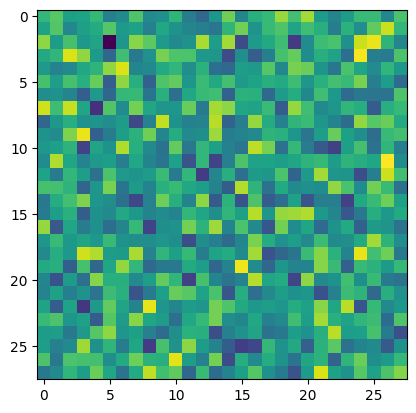

In [19]:
plt.imshow(output[0].reshape(28,28).detach().numpy())
plt.show()

In [20]:
discriminator = MLP(28*28, 1)
output = discriminator(torch.randn(64, 28*28))
output.shape

torch.Size([64, 1])

In [16]:
from fastprogress import master_bar, progress_bar

def fit(g, d, dataloader, epochs=30, crit=None):
  g.to(device)
  d.to(device)
  g_optimizer = torch.optim.Adam(g.parameters(), lr=3e-4)
  d_optimizer = torch.optim.Adam(d.parameters(), lr=3e-4)
  crit = nn.BCEWithLogitsLoss() if crit == None else crit
  g_loss, d_loss = [], []
  mb = master_bar(range(1, epochs+1))
  hist = {'g_loss': [], 'd_loss': []}
  for epoch in mb:
    
    for X, y in progress_bar(dataloader, parent=mb):
      #X, y = X.to(device), y.to(device)  
      # entrenamos el discriminador
      g.eval()
      d.train()
      #   generamos un batch de imágenes falsas
      noise = torch.randn((X.size(0), g.input_size)).to(device)
      genenerated_images = g(noise)
      #   input del discrminator
      d_input = torch.cat([genenerated_images, X.view(X.size(0), -1)])
      #   gorund truth para el discriminator
      d_gt = torch.cat([torch.zeros(X.size(0)), torch.ones(X.size(0))]).view(-1,1).to(device)
      #   optimización
      d_optimizer.zero_grad()
      d_output = d(d_input)
      d_l = crit(d_output, d_gt)
      d_l.backward()
      d_optimizer.step()
      d_loss.append(d_l.item())
      # entrenamos el generador
      g.train()
      d.eval()
      #   generamos un batch de imágenes falsas
      noise = torch.randn((X.size(0), g.input_size)).to(device)
      genenerated_images = g(noise)
      #   salidas del discriminador
      d_output = d(genenerated_images)
      #   gorund truth para el generator
      g_gt = torch.ones(X.size(0)).view(-1,1).to(device)
      #   optimización
      g_optimizer.zero_grad()
      g_l = crit(d_output, g_gt)
      g_l.backward()
      g_optimizer.step()
      g_loss.append(g_l.item())
      # logs
      mb.child.comment = f'g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}'
    mb.write(f'Epoch {epoch}/{epochs} g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}')
    hist['g_loss'].append(np.mean(g_loss))    
    hist['d_loss'].append(np.mean(d_loss))
  return hist

In [29]:
hist = fit(generator, discriminator, train_loader)

RuntimeError: ignored